# Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Flatten, Input, Embedding, Dot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler

from wordcloud import WordCloud
from collections import defaultdict
%matplotlib inline


# Reading Data from animelist

In [2]:
INPUT_DIR = os.path.join('..','artifacts','raw')
#INPUT_DIR = '/content/drive/MyDrive/'
INPUT_DIR

'../artifacts/raw'

In [3]:
rating_df = pd.read_csv(INPUT_DIR+'/animelist.csv', low_memory=True, usecols=['user_id','anime_id','rating'])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


## EDA

In [4]:
f'{len(rating_df):,}'

'15,000,000'

In [5]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000000 entries, 0 to 14999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 343.3 MB


In [6]:
# Descriptive statistics for ratings

rating_df.rating.describe()

count    1.500000e+07
mean     4.260116e+00
std      3.911124e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

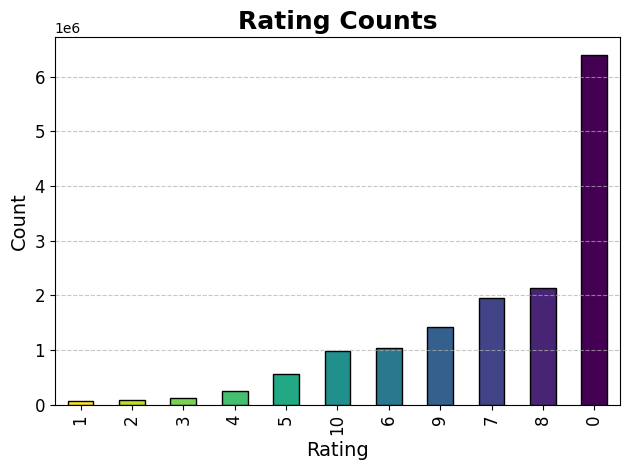

In [7]:
# Rating distribution

rating_counts = rating_df.rating.value_counts().sort_values()
colors = plt.cm.viridis_r(np.linspace(0, 1, len(rating_counts)))

# Plot
rating_counts.plot(kind='bar', color=colors, edgecolor='black')

# Add titles and labels
plt.title('Rating Counts', fontsize=18, fontweight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


We need to figure out the experiened and active users who can help in the reccomendation system

In [8]:
# The number of ratings each user has given which indicates how experienced that user is
n_ratings = rating_df.user_id.value_counts()
n_ratings

user_id
20807    17546
11100    14429
22022    13696
16869     8943
38143     8544
         ...  
15202        1
17092        1
45924        1
22906        1
36971        1
Name: count, Length: 44879, dtype: int64

In [9]:
# Extract users who have rated more than 200 animes as experienced users
rating_df = rating_df[rating_df.user_id.isin(n_ratings[n_ratings>=400].index)].copy()

In [10]:
f'{len(rating_df):,}'

'9,816,491'

### Feature scaling
Since the ratings are in a range of 0-10, we would scale it using min max scaling to normalise the values to a range of 0-1

In [11]:
min_rating = min(rating_df.rating)
max_rating = max(rating_df.rating)
min_rating, max_rating

(0, 10)

In [12]:
rating_df['rating'] = rating_df.rating.apply(lambda x: (x-min_rating)/(max_rating-min_rating))


In [13]:
rating_df.rating.describe()

count    9.816491e+06
mean     4.058961e-01
std      3.849884e-01
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e-01
75%      8.000000e-01
max      1.000000e+00
Name: rating, dtype: float64

### Check for duplicates and nulls

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Encode user and anime ids

In [16]:
user_ids = rating_df.user_id.unique().tolist()
anime_ids = rating_df.anime_id.unique().tolist()
n_users = len(user_ids)
n_anime = len(anime_ids)
print(f'Number of unique users: {n_users}\nNumber of animes: {n_anime}')

Number of unique users: 12576
Number of animes: 17554


In [17]:
encoded_user = {x : i for i , x in enumerate(user_ids)}
decoded_user = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df.user_id.map(encoded_user)

encoded_anime = {x:i for i,x in enumerate(anime_ids)}
decoded_anime = {i:x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df.anime_id.map(encoded_anime)

rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [18]:
# Shuffle the data
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)
rating_df.head()

,user_id,anime_id,rating,user,anime
0,6298,44,0.9,1587,2402
1,20198,38020,0.0,5160,5625
2,7106,860,0.7,1787,2602
3,23585,1901,0.0,6014,2213
4,30880,28297,1.0,7908,2377


## Train Test Split

In [19]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [20]:
test_size = 1000
train_idx = rating_df.shape[0] - test_size

In [21]:
X_train, X_test, y_train, y_test = (
    X[:train_idx],
    X[train_idx:],
    y[:train_idx],
    y[train_idx:]
)


In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9815491, 2), (1000, 2), (9815491,), (1000,))

In [23]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

## Model Architecture

In [25]:
def RecommenderNet():
    """
    Builds and returns a deep learning-based collaborative filtering recommender model using user and anime embeddings.

    The model learns latent features for users and anime through embedding layers,
    computes the cosine similarity between them, and uses a sigmoid output to predict
    the probability that a user will like a given anime.

    Returns:
        model (tf.keras.Model): A compiled Keras model ready for training.
    """
    
    embedding_size = 128  # Size of the embedding vector for both users and anime

    # Input layer for user ID (expects a single integer per input)
    user = Input(name="user", shape=[1])

    # Embedding layer to learn a dense representation of users
    user_embedding = Embedding(
        name="user_embedding",
        input_dim=n_users,               # Total number of unique users
        output_dim=embedding_size        # Size of the embedding vector
    )(user)

    # Input layer for anime ID (expects a single integer per input)
    anime = Input(name="anime", shape=[1])

    # Embedding layer to learn a dense representation of anime
    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim=n_anime,               # Total number of unique animes
        output_dim=embedding_size
    )(anime)

    # Dot product of normalized embeddings (cosine similarity)
    x = Dot(
        name="dot_product",
        normalize=False,                  
        axes=2
    )([user_embedding, anime_embedding])

    # Flatten the result to a 1D tensor
    x = Flatten()(x)

    # Dense layer to transform the similarity score
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs=[user, anime], outputs=x)

    # Compile the model with binary crossentropy loss and Adam optimizer
    model.compile(
        loss="binary_crossentropy",     
        metrics=["mae", "mse"],         
        optimizer=Adam()
    )

    return model


In [26]:
model = RecommenderNet()

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,609,728 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,912 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,856,646 (14.71 MB)

 Trainable params: 3,856,644 (14.71 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
# Learning rate schedule parameters
start_lr = 0.00001   # Starting LR at epoch 0
max_lr = 0.0001      # Peak LR reached after ramp-up
min_lr = 0.00005     # Final LR after decay


rampup_epochs = 5    # Number of epochs to linearly increase LR
sustain_epochs = 0   # Number of epochs to sustain max LR before decay
exp_decay = 0.8      # Exponential decay rate after ramp-up/sustain

# Based on stack overflow post: 
# https://stackoverflow.com/questions/61520180/how-to-improve-val-loss-and-val-acc
def lrfn(epoch):
    if epoch < rampup_epochs:
        # Linear ramp-up from start_lr to max_lr
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        # Sustain max_lr for sustain_epochs
        return max_lr
    else:
        # Exponential decay from max_lr down to min_lr
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr


In [28]:
checkpoint_filepath = './weights.weights.h5'

In [29]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only=True,
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor="val_loss",
                               mode="min",
                               restore_best_weights=True)

In [30]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [32]:
batch_size = 10000

history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/50
982/982 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.7052 - mae: 0.3657 - mse: 0.1628 - val_loss: 0.7053 - val_mae: 0.3704 - val_mse: 0.1654 - learning_rate: 1.0000e-05
Epoch 2/50
982/982 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.7020 - mae: 0.3650 - mse: 0.1613 - val_loss: 0.7007 - val_mae: 0.3699 - val_mse: 0.1632 - learning_rate: 2.8000e-05
Epoch 3/50
982/982 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.6951 - mae: 0.3631 - mse: 0.1580 - val_loss: 0.6927 - val_mae: 0.3681 - val_mse: 0.1593 - learning_rate: 4.6000e-05
Epoch 4/50
982/982 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.6818 - mae: 0.3578 - mse: 0.1515 - val_loss: 0.6619 - val_mae: 0.3492 - val_mse: 0.1443 - learning_rate: 6.4000e-05
Epoch 5/50
982/982 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.6282 - mae: 0.3213 - mse: 0.1259 - val_loss: 0.5930 - val_mae: 0.2904 - val_mse: 0.1129 - learning_rate: 8.2000e-05
Epoch 6/50
982/982 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5663 - mae: 0.2695 - mse: 0.0988 - v

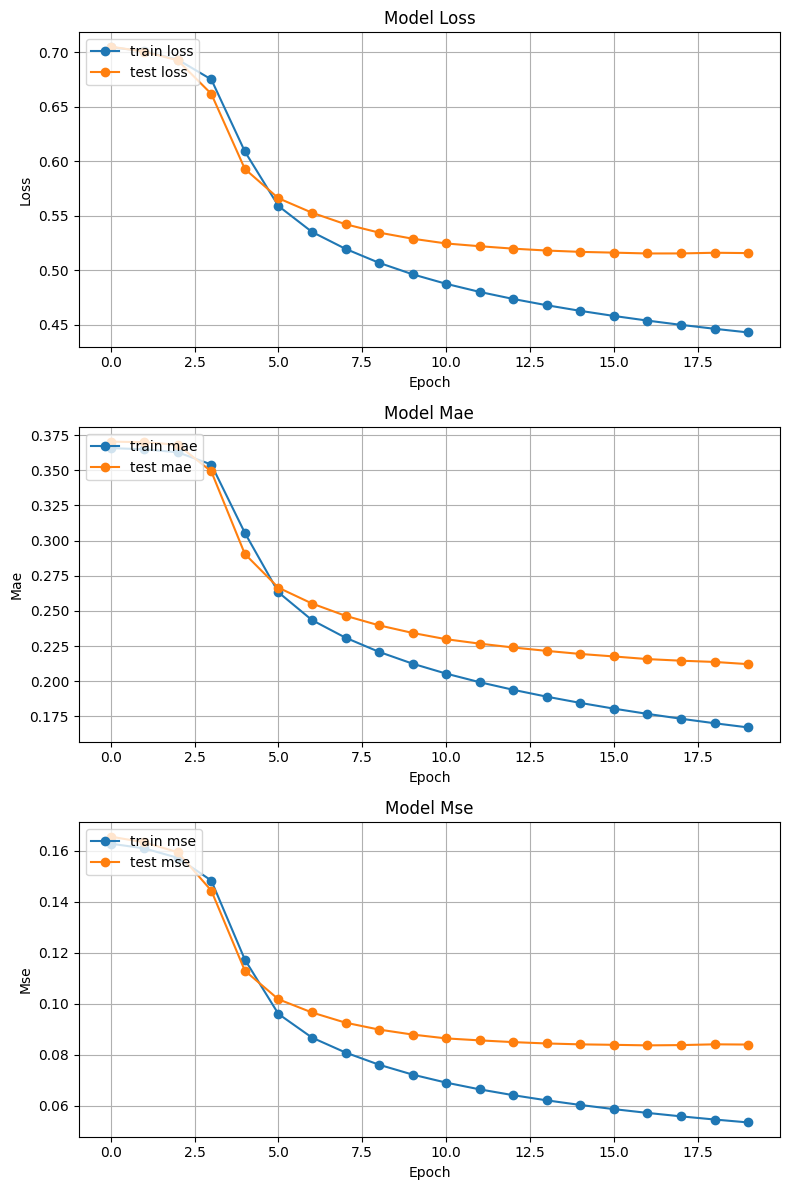

In [33]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [32]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [33]:
anime_weights = extract_weights("anime_embedding",model)
user_weights = extract_weights("user_embedding",model)

In [34]:
anime_weights.shape, user_weights.shape

((17554, 128), (12576, 128))

In [31]:
checkpoint_filepath = './weights.weights.h5'

model.load_weights(checkpoint_filepath)

/Users/vikramjitbora/Downloads/Projects/mlops_1/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Read data from anime.csv

In [35]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [36]:
df = df.replace("Unknown",np.nan)

In [37]:
# Check rows that have Name column but NaN in English Name column
df[df['English name'].isna() & df['Name'].notna()]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",NaN,アイシールド21,TV,145,"Apr 6, 2005 to Mar 19, 2008",Spring 2005,...,9226.0,14904.0,22811.0,16734.0,6206.0,2621.0,795.0,336.0,140.0,151.0
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",NaN,ハングリーハート Wild Striker,TV,52,"Sep 11, 2002 to Sep 10, 2003",Fall 2002,...,1123.0,1777.0,3102.0,3075.0,1286.0,602.0,218.0,88.0,31.0,32.0
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",NaN,頭文字〈イニシャル〉D FOURTH STAGE,TV,24,"Apr 17, 2004 to Feb 18, 2006",Spring 2004,...,10948.0,15820.0,22379.0,12912.0,3874.0,1236.0,369.0,97.0,48.0,259.0
13,23,Ring ni Kakero 1,6.38,"Action, Shounen, Sports",NaN,リングにかけろ１,TV,12,"Oct 6, 2004 to Dec 15, 2004",Fall 2004,...,69.0,61.0,152.0,260.0,236.0,143.0,88.0,40.0,32.0,28.0
19,29,Zipang,7.51,"Action, Military, Sci-Fi, Historical, Drama, S...",NaN,ジパング,TV,26,"Oct 8, 2004 to Apr 1, 2005",Fall 2004,...,430.0,874.0,1801.0,1696.0,662.0,279.0,114.0,38.0,13.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17556,48480,Wan Jie Shen Zhu 3rd Season,NaN,"Adventure, Fantasy",NaN,万界神主 第三季,ONA,48,"Mar 17, 2021 to ?",NaN,...,NaN,NaN,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.rename({'MAL_ID':'anime_id'}, axis=1, inplace=True)
df.rename({'English name':'eng_version'}, axis=1, inplace=True)

In [39]:
df.columns

Index(['anime_id', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [40]:
def getAnimeName(anime_id):
    try:
        row = df[df.anime_id == anime_id].iloc[0]
        name = row.Name if pd.isna(row.eng_version) else row.eng_version
        return name
    except IndexError:
        print(f"Anime ID {anime_id} not found in DataFrame.")
    except Exception as e:
        print(f"Unexpected error while retrieving anime name: {e}")
    return None

In [42]:
df.rename({'English name':'eng_version'}, axis=1, inplace=True)
getAnimeName(6704)

"Queen's Blade:The Exiled Virgin"

In [43]:
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [44]:
df.columns

Index(['anime_id', 'Name', 'Score', 'Genres', 'eng_version', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [45]:
df = df[["anime_id" , "Name", "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   anime_id       17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          12421 non-null  object
 3   Genres         17499 non-null  object
 4   eng_version    17562 non-null  object
 5   Japanese name  17514 non-null  object
 6   Type           17525 non-null  object
 7   Episodes       17046 non-null  object
 8   Aired          17253 non-null  object
 9   Premiered      4745 non-null   object
 10  Producers      9768 non-null   object
 11  Licensors      3946 non-null   object
 12  Studios        10483 non-null  object
 13  Source         13995 non-null  object
 14  Duration       17007 non-null  object
 15  Rating         16874 non-null  object
 16  Ranked         15800 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [47]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [48]:
df.head()

,anime_id,Name,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Shingeki no Kyojin: The Final Season,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama°,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [49]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        result = df[df.anime_id == anime]
    elif isinstance(anime, str):
        result = df[df.eng_version == anime]
    else:
        raise ValueError("Anime must be an int (anime_id) or str (eng_version)")
    if result.empty:
        return np.nan  
    return result

In [50]:
getAnimeFrame(6701 , df)

,anime_id,Name,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4706,6701,Jim Button,Jim Button,NaN,"Kids, Adventure, Fantasy, Magic",26,TV,Fall 1974,336


In [51]:
getAnimeFrame("Steins;Gate",df)

,anime_id,Name,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


# Reading data from anime_with_synopsis

In [52]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [53]:
def getSynopsis(anime,synopsis_df):
    try:
        if isinstance(anime,int):
            return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
        if isinstance(anime,str):
            return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    except IndexError:
        return np.nan

In [54]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

# Content based recommendation

In [55]:
def find_similar_animes(name, anime_weights, encoded_anime, decoded_anime, df, synopsis_df, n=10, return_dist=False, neg=False):
    """
    Find and return a list of animes similar to a given anime based on precomputed weights.

    Args:
        name (str): Name of the anime to find similarities for.
        anime_weights (np.ndarray): Weight matrix representing anime features.
        encoded_anime (dict): Mapping of anime IDs to encoded indices.
        decoded_anime (dict): Mapping of encoded indices back to anime IDs.
        df (pd.DataFrame): DataFrame containing anime metadata (e.g., ID, name, genres).
        synopsis_df (pd.DataFrame): DataFrame containing anime synopses.
        n (int, optional): Number of similar animes to retrieve. Defaults to 10.
        return_dist (bool, optional): Whether to return distances and indices instead of full info. Defaults to False.
        neg (bool, optional): If True, find least similar animes instead of most similar. Defaults to False.

    Returns:
        pd.DataFrame or tuple: 
            - If return_dist is True, returns (distances, closest indices).
            - Else, returns a DataFrame of similar animes with columns: ['name', 'similarity', 'genre', 'synopsis'].
    
    Raises:
        ValueError: If the anime name is not found in the provided dataset or if encoded index is missing.
    """
    try:
        # Get the anime_id for the given anime name
        anime_frame = getAnimeFrame(name, df)
        if anime_frame is None or anime_frame.empty:
            raise ValueError(f"Anime '{name}' not found in the dataset.")

        index = anime_frame.anime_id.values[0]
        encoded_index = encoded_anime.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")

        weights = anime_weights

        # Compute cosine similarity (dot product) between target anime and all others
        dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
        sorted_dists = np.argsort(dists)

        # Adjust n because the anime itself will be the most similar
        n = n + 1

        # Choose closest or farthest based on 'neg' flag
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        # If distances and indices are required directly
        if return_dist:
            return dists, closest

        # Build the result list
        SimilarityArr = []
        for close in closest:
            decoded_id = decoded_anime.get(close)
            if decoded_id is None:
                print(f"Warning: No decoded anime found for encoded index {close}. Skipping.")
                continue

            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, df)

            if anime_frame is None or anime_frame.empty:
                print(f"Warning: Anime ID {decoded_id} not found in metadata. Skipping.")
                continue

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })

        # Create final DataFrame and remove the original anime from the list
        result_frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        result_frame = result_frame[result_frame.anime_id != index].drop(['anime_id'], axis=1)

        return result_frame

    except Exception as e:
        print(f"An error occurred in find_similar_animes: {str(e)}")


In [68]:
find_similar_animes('Cowboy Bebop',
                    anime_weights=anime_weights,
                    encoded_anime=encoded_anime,
                    decoded_anime=decoded_anime,
                    df=df,
                    synopsis_df=synopsis_df)

,name,similarity,genre,synopsis
9,Cowboy Bebop:The Movie,0.685329,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
8,FLCL,0.665244,"Action, Sci-Fi, Comedy, Parody, Dementia, Psyc...",Naota Nandaba is an ordinary sixth grader livi...
7,Ghost in the Shell,0.662720,"Action, Mecha, Police, Psychological, Sci-Fi, ...","In the year 2029, Niihama City has become a te..."
6,Neon Genesis Evangelion,0.648397,"Action, Sci-Fi, Dementia, Psychological, Drama...","In the year 2015, the world stands on the brin..."
5,Samurai Champloo,0.641253,"Action, Adventure, Comedy, Historical, Samurai...",Fuu Kasumi is a young and clumsy waitress who ...
4,AKIRA,0.631582,"Action, Military, Sci-Fi, Adventure, Horror, S...","Japan, 1988. An explosion caused by a young bo..."
3,Trigun,0.605293,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
2,Neon Genesis Evangelion:The End of Evangelion,0.530105,"Sci-Fi, Dementia, Psychological, Drama, Mecha","h the final Angel vanquished, Nerv has one las..."
1,Perfect Blue,0.518275,"Dementia, Drama, Horror, Psychological",J-pop idol group CHAM! has spent the last two ...
0,Hellsing,0.516284,"Action, Horror, Supernatural, Vampire, Seinen","Hellsing, an organization specializing in deal..."


# User based recommendation

In [69]:
def find_similar_users(user_id, user_weights, encoded_user, decoded_user, n=10, return_dist=False, neg=False):
    """
    Finds users similar to a given user based on user embedding weights.

    Args:
        user_id (int or str): ID of the user for whom similar users are to be found.
        user_weights (np.ndarray): Array containing the encoded user vectors.
        encoded_user (dict): Dictionary mapping original user IDs to their index in the encoded user weights.
        decoded_user (dict): Dictionary mapping indices back to original user IDs.
        n (int, optional): Number of similar users to return. Defaults to 10.
        return_dist (bool, optional): If True, returns the distance array and indices of closest users. Defaults to False.
        neg (bool, optional): If True, retrieves users with least similarity (negative matches). Defaults to False.

    Returns:
        pd.DataFrame or tuple:
            - If return_dist is False: DataFrame with 'similar_users' and 'similarity' columns.
            - If return_dist is True: Tuple of (distance array, indices of similar users).

    Raises:
        ValueError: If the user_id is not found in encoded_user mapping.
        Exception: For any other unexpected errors.
    """
    try:
        # Get the encoded index for the provided user_id
        encoded_index = encoded_user.get(user_id)
        if encoded_index is None:
            raise ValueError(f"User ID {user_id} not found in encoded_user mapping.")

        weights = user_weights

        # Calculate dot product similarity between users
        dists = np.dot(weights, weights[encoded_index])

        # Sort the distances to find closest users
        sorted_dists = np.argsort(dists)

        # Adjust n to include the user itself
        n += 1

        # Select top n similar or dissimilar users based on 'neg'
        if neg:
            closest = sorted_dists[:n]  # least similar (negative matches)
        else:
            closest = sorted_dists[-n:]  # most similar

        # If raw distances and indices are requested
        if return_dist:
            return dists, closest

        # Prepare list to store similar users and their similarity scores
        similarity_arr = []

        for close in closest:
            similarity = dists[close]

            # Decode the user ID from index
            decoded_id = decoded_user.get(close)

            if decoded_id is not None and decoded_id != user_id:
                similarity_arr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })

        # Create a DataFrame of similar users
        similar_users = pd.DataFrame(similarity_arr).sort_values(by="similarity", ascending=False)

        return similar_users

    except ValueError as ve:
        print(f"ValueError: {ve}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [70]:
find_similar_users(46508, user_weights, encoded_user, decoded_user)

,similar_users,similarity
9,25082,0.815034
8,31642,0.808453
7,11300,0.808262
6,25546,0.807745
5,45354,0.806152
4,24693,0.805775
3,15889,0.801962
2,9229,0.796288
1,4074,0.793465
0,29746,0.793348


In [71]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [72]:
def getFavGenre(frame , plot=False):
    frame.dropna()
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list


In [73]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    """
    Extracts a user's preferred anime genres based on their top-rated animes.

    Args:
        user_id (int): ID of the user whose preferences are to be extracted.
        rating_df (pd.DataFrame): DataFrame containing user ratings with at least 'user_id', 'anime_id', and 'rating' columns.
        df (pd.DataFrame): DataFrame containing anime details with at least 'anime_id', 'eng_version', and 'Genres' columns.
        plot (bool, optional): Whether to plot the user's favorite genres. Defaults to False.

    Returns:
        pd.DataFrame: DataFrame containing 'eng_version' and 'Genres' of the user's top-rated animes.
    """
    try:
        # Filter ratings for the specific user
        animes_watched_by_user = rating_df[rating_df.user_id == user_id]
        if animes_watched_by_user.empty:
            raise ValueError(f"No ratings found for user_id: {user_id}")

        # Calculate the 75th percentile of the user's ratings
        user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

        # Select animes rated above or equal to the 75th percentile
        high_rated_animes = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

        # Get the anime IDs sorted by rating in descending order
        top_animes_user = (
            high_rated_animes.sort_values(by="rating", ascending=False).anime_id.values
        )

        # Filter the anime details dataframe for selected anime IDs
        anime_df_rows = df[df["anime_id"].isin(top_animes_user)][["eng_version", "Genres"]]

        # Optionally plot the favorite genres
        if plot:
            getFavGenre(anime_df_rows, plot)

        return anime_df_rows

    except ValueError as ve:
        print(f"ValueError: {ve}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [74]:
get_user_preferences(11880, rating_df, df)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [85]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10):
    """
    Generates anime recommendations for a user based on preferences of similar users.

    Args:
        similar_users (pd.DataFrame): DataFrame with columns ['similar_users', 'similarity'] for similar users.
        user_pref (pd.DataFrame): DataFrame of the user's highly-rated animes.
        df (pd.DataFrame): DataFrame containing anime details with at least 'anime_id', 'eng_version', and 'Genres'.
        synopsis_df (pd.DataFrame): DataFrame containing anime synopsis with 'anime_id' and 'synopsis' columns.
        rating_df (pd.DataFrame): DataFrame containing user ratings.
        n (int, optional): Number of anime recommendations to return. Defaults to 10.

    Returns:
        pd.DataFrame: DataFrame with top recommended animes containing 'n', 'anime_name', 'Genres', and 'Synopsis'.

    Raises:
        ValueError: If similar_users DataFrame is empty.
        Exception: For any unexpected errors.
    """
    try:
        if similar_users.empty:
            raise ValueError("No similar users found to base recommendations on.")

        recommended_animes = []
        anime_list = []

        # Loop over each similar user to find their preferred animes
        for user_id in similar_users.similar_users.values:
            pref_list = get_user_preferences(int(user_id), rating_df, df)

            # Exclude animes already watched by the original user
            pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

            if not pref_list.empty:
                anime_list.append(pref_list.eng_version.values)

        if anime_list:
            # Flatten the list and count frequency of each anime
            anime_list_flat = pd.Series(np.concatenate(anime_list))  # Use np.concatenate
            sorted_list = anime_list_flat.value_counts().head(n)

            # Build the recommendation list
            for anime_name, n_user_pref in sorted_list.items():
                if isinstance(anime_name, str):
                    try:
                        frame = getAnimeFrame(anime_name, df)

                        if frame.empty:
                            continue

                        anime_id = frame.anime_id.values[0]
                        genre = frame.Genres.values[0]
                        synopsis = getSynopsis(int(anime_id), synopsis_df)

                        recommended_animes.append({
                            "n": n_user_pref,
                            "anime_name": anime_name,
                            "Genres": genre,
                            "Synopsis": synopsis
                        })

                    except Exception as e:
                        print(f"Warning: Could not fetch details for anime '{anime_name}': {e}")
                        continue

        return pd.DataFrame(recommended_animes).head(n)

    except ValueError as ve:
        print(f"ValueError: {ve}")
        raise

    except Exception as e:
        print(f"An unexpected error occurred during recommendation generation: {e}")
        raise


In [88]:
similar_users =find_similar_users(int(11880),user_weights,encoded_user,decoded_user)
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=5)

,n,anime_name,Genres,Synopsis
0,8,Steins;Gate,"Thriller, Sci-Fi",The self-proclaimed mad scientist Rintarou Oka...
1,8,Sword Art Online,"Action, Game, Adventure, Romance, Fantasy","In the year 2022, virtual reality has progress..."
2,8,anohana:The Flower We Saw That Day,"Slice of Life, Supernatural, Drama",Jinta Yadomi is peacefully living as a recluse...
3,7,Attack on Titan,"Action, Military, Mystery, Super Power, Drama,...","Centuries ago, mankind was slaughtered to near..."
4,7,Spirited Away,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chih..."


# Hybrid recommendation 

In [ ]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    """
    Generates a hybrid anime recommendation list based on user similarity and content similarity.

    Args:
        user_id (int): ID of the user for whom recommendations are to be generated.
        user_weight (float, optional): Weight for user-based recommendations. Defaults to 0.5.
        content_weight (float, optional): Weight for content-based recommendations. Defaults to 0.5.

    Returns:
        list: Top 10 recommended anime names sorted by combined hybrid scores.
    """
    try:
        # Step 1: User-based Recommendation
        
        # Find similar users based on user preferences
        similar_users = find_similar_users(user_id, user_weights, encoded_user, decoded_user)
        
        # Retrieve the current user's preferences
        user_pref = get_user_preferences(user_id, rating_df, df)
        
        # Generate recommendations based on similar users
        user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)
        user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

        print(user_recommended_anime_list)

        # Step 2: Content-based Recommendation
        content_recommended_animes = []

        for anime in user_recommended_anime_list:
            try:
                # Find similar animes for each user-recommended anime
                similar_animes = find_similar_animes(anime, anime_weights, encoded_anime, decoded_anime, df, synopsis_df)

                if similar_animes is not None and not similar_animes.empty:
                    content_recommended_animes.extend(similar_animes["name"].tolist())
                else:
                    print(f"No similar anime found for: {anime}")
            except Exception as e:
                print(f"Error finding similar animes for {anime}: {e}")

        # Step 3: Combining Scores

        combined_scores = {}

        # Add user-based recommendation scores
        for anime in user_recommended_anime_list:
            combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

        # Add content-based recommendation scores
        for anime in content_recommended_animes:
            combined_scores[anime] = combined_scores.get(anime, 0) + content_weight  

        # Sort animes by combined score in descending order
        sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

        # Return top 10 recommended anime names
        return [anime for anime, _ in sorted_animes[:10]]

    except Exception as e:
        print(f"An error occurred during hybrid recommendation generation: {e}")
        return []


In [90]:
hybrid_recommendation(11880)

['Steins;Gate', 'Sword Art Online', 'anohana:The Flower We Saw That Day', 'Attack on Titan', 'Spirited Away', 'Noragami Aragoto', 'No Game, No Life', 'My Neighbor Totoro', 'Your Lie in April', 'Aldnoah.Zero']


['ERASED',
 'Tokyo Ghoul',
 'Sword Art Online',
 'Attack on Titan',
 'No Game, No Life',
 'Re:ZERO -Starting Life in Another World-',
 'Akame ga Kill!',
 'One Punch Man',
 'anohana:The Flower We Saw That Day',
 'Spirited Away']